# Analisa dados do ENEM

Lê os dados pré-processados que foram gerados pelo notebook `ledados.ipynb` e os analisa. Vá para o final para ver os ranking final.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set()
import IPython

%matplotlib inline
# pd.options.display.max_rows = None
# pd.options.display.max_columns = None

In [2]:
# %load const
CO_STO_AGOS_NL = 33087679
CO_STO_AGO_INST = 33176825
CO_STO_AGO = 33020566
CO_SAO_BENTO = 33062633
CO_SAO_VICENTE = 33063648
CO_PARQUE = 33065837
CO_ELEVA = 33178860
CO_ST_INACIO = 33063729
CO_SAO_VICENTE = 33063648


CO_MUN = 3304557  # Rio de Janeiro
CO_UF_RIO = 33  # RJ

MIN_ALUNOS = 30  # Mínimo de alunos fazendo Enem para considerar na análise
NUM_MELHORES = 60
ANO_ULT = 2019  # último ano a processar

In [3]:
from const import ANO_ULT

In [4]:
df_escolas = pd.read_feather(f"dados/escolas_rio_{ANO_ULT}.feather")
df_primeiro_ano_turmas = pd.read_feather("dados/primeiro_ano.feather")

In [5]:
df_enem_rio = pd.read_feather(f"dados/enem_rio_{ANO_ULT}.feather").query(
    "TP_ST_CONCLUSAO == 2" # concluiu ensino médio no ano da prova 
    + "and TP_ENSINO == 1"   # ensino regular, sem educação jovens e adultos nem supletivos
)

In [6]:
df_enem_rio = pd.read_feather(f"dados/enem_rio_{ANO_ULT}.feather")
print(df_enem_rio.size)
# df_enem_rio = df_enem_rio.query("TP_ST_CONCLUSAO == 2")
# print(df_enem_rio.size)
# df_enem_rio = df_enem_rio.query("TP_ENSINO == 1")
# print(df_enem_rio.size)
# import pandas_profiling
# pandas_profiling.ProfileReport(df_enem_rio)

10012782


In [7]:
df_enem_rio.head()

,index,NU_INSCRICAO,NU_ANO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,...,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025
0,144,190001517230,2019,3300100,Angra dos Reis,33,RJ,18.0,F,1,...,B,A,B,D,B,A,D,A,A,B
1,251,190001517237,2019,3305802,Teresópolis,33,RJ,18.0,F,1,...,B,A,A,B,A,A,C,A,B,B
2,323,190001520685,2019,3303906,Petrópolis,33,RJ,20.0,F,1,...,A,A,A,A,B,A,C,A,B,A
3,423,190001520689,2019,3301702,Duque de Caxias,33,RJ,22.0,F,1,...,A,A,A,B,A,A,B,B,A,A
4,487,190001520694,2019,3302106,Itaocara,33,RJ,17.0,M,1,...,A,A,A,C,B,A,D,A,B,B


 ## Cálculo da nota final
 Abaixo pode-se personalizar o cálculo de nota final. pondero pelas notas mais importantes.

 O Inep costuma considerar a redação como tendo um peso igual às outras disciplinas.

 Algumas universidades consideram um peso distinto de acordo com a disciplina

 ### Pesos UFRJ

 Referência dos [pesos da UFRJ](https://oglobo.globo.com/sociedade/educacao/ufrj-usara-pesos-diferentes-em-provas-do-enem-2011-para-acesso-aos-cursos-de-graduacao-2865665).

 - Redação: peso 3 (mínimo 300)
 - Ciência da Computação, Ciências Atuariais, Engenharias, Estatística, Matemática e Química Industrial
     - Matemática tem peso 4
 - Ciências Econômicas, Geologia e Meteorologia
     - Matemática peso 3
 - Engenharias e Química Industrial
     - Ciências da Natureza: peso 4
 - Geologia
     - Ciências da Natureza: peso 3
 - Humanas
     - Ciências Humanas e Linguagens: peso 2



In [8]:
notas_cols = [
    "NU_NOTA_CN",
    "NU_NOTA_CH",
    "NU_NOTA_LC",
    "NU_NOTA_MT",
    "NU_NOTA_REDACAO",
]
notas_pesos = (1, 1, 1, 1, 4)  # peso do Inep com redação igual à soma dos demais
notas_pesos = (1, 1, 1, 1,1)  # peso do Inep com redação igual os demais
notas_pesos = (1, 1, 1, 1, 2)  # peso do Inep com redação peso 2 (é mais parecido com o normal)

In [9]:
media_ponderada = lambda notas: np.average(notas, weights=notas_pesos)

# df_enem_rio me dá as notas do enem de cada aluno de escola do rio de janeiro
df_enem_rio["nota_final"] = (
    df_enem_rio.loc[df_enem_rio.TP_ST_CONCLUSAO == 2, notas_cols]
    .apply(media_ponderada, axis=1)
    .round(0)
)
df_enem_rio[notas_cols + ["nota_final"]].head()

,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,nota_final
0,402.9,509.7,534.2,451.9,500.0,483.0
1,502.4,449.4,547.2,465.5,540.0,507.0
2,511.5,495.1,533.2,596.3,620.0,563.0
3,468.8,480.3,502.9,445.1,400.0,450.0
4,459.8,629.1,573.4,675.1,880.0,683.0


In [10]:
# df_enem sãos as notas agrupadas por escola e ordenadas da melhor para a pior
def notas_enem(df_enem_rio):
    notas_agg = {col: (col, "median") for col in notas_cols}
    notas_agg["mediana"] = ("nota_final", "median")
    notas_agg["num"] = ("nota_final", "count")

    return (
        df_enem_rio.groupby("CO_ESCOLA")
        .agg(**notas_agg)
        .sort_values("mediana", ascending=False)
        .query("num > @MIN_ALUNOS")
    )  # corte arbitrário


df_enem = notas_enem(df_enem_rio)
df_enem

,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,mediana,num
CO_ESCOLA,,,,,,,
33135827,647.70,650.80,626.90,788.90,940.0,758.0,31
33062633,636.60,671.90,626.10,789.60,900.0,751.0,45
33178860,609.80,661.90,625.90,779.00,900.0,745.5,60
33135371,613.20,647.00,620.30,743.80,940.0,743.0,99
33176825,605.55,649.05,620.45,759.25,920.0,742.0,146
...,...,...,...,...,...,...,...
33025754,429.30,465.45,503.95,451.70,480.0,464.0,59
33049726,420.20,461.85,487.65,450.60,450.0,462.0,55
33100080,424.20,449.70,488.20,456.50,460.0,450.5,34


In [11]:
df_enem["rank"] = df_enem.mediana.rank(ascending=False, method="min")

In [71]:
df_enem_rio_g = df_enem_rio.groupby('CO_ESCOLA')
df_enem_bins = pd.concat(
    [df_enem_rio_g[c].value_counts(bins=np.arange(-25, 1026, 50)) for c in notas_cols  + ['nota_final'] ]
    , axis=1).reset_index()
df_enem_bins['bins'] = df_enem_bins.level_1.astype(str)
df_enem_bins['bin_label'] = df_enem_bins.level_1.apply(lambda x: int((x.left+25.1) ))

df_enem_bins.drop('level_1', axis=1, inplace=True)
df_enem_bins.to_feather('enem_rio_bins.feather')

In [14]:
# vamos colocar o nome das escolas
df_enem = df_enem.merge(
    df_escolas[["NO_ENTIDADE", "CO_ENTIDADE"]], left_index=True, right_on="CO_ENTIDADE"
)

In [15]:
df_enem

,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,mediana,num,rank,NO_ENTIDADE,CO_ENTIDADE
1603,647.70,650.80,626.90,788.90,940.0,758.0,31,1.0,COLEGIO E CURSO PENSI,33135827
1230,636.60,671.90,626.10,789.60,900.0,751.0,45,2.0,COL DE SAO BENTO,33062633
1967,609.80,661.90,625.90,779.00,900.0,745.5,60,3.0,ESCOLA ELEVA,33178860
214,613.20,647.00,620.30,743.80,940.0,743.0,99,4.0,COLEGIO CRUZEIRO - JACAREPAGUA,33135371
244,605.55,649.05,620.45,759.25,920.0,742.0,146,5.0,COLEGIO SANTO AGOSTINHO - UNIDADE INSTITUTO CU...,33176825
...,...,...,...,...,...,...,...,...,...,...
528,420.90,444.95,493.95,491.00,490.0,464.0,37,584.0,CIEP 281 GABRIELA MISTRAL,33041946
1837,429.30,465.45,503.95,451.70,480.0,464.0,59,584.0,CE SERVULO MELO,33025754
782,420.20,461.85,487.65,450.60,450.0,462.0,55,586.0,CIEP 089 GRACILIANO RAMOS,33049726
839,424.20,449.70,488.20,456.50,460.0,450.5,34,587.0,CIEP 207 GILSON AMADO,33100080


Respondendo uma pergunta sinistra: quantas escolas com ensino médio não tiveram qualquer aluno fazendo Enem?

ih, não dá, já filtrei o df_enem

In [16]:
my_order = df_enem.head(NUM_MELHORES).NO_ENTIDADE

Ajustando nomes de escolas. Estão muito grandes. 


In [17]:
df_nomes_grandes = df_enem[:100][["CO_ENTIDADE", "NO_ENTIDADE"]]
df_nomes_grandes["comprido"] = df_nomes_grandes.NO_ENTIDADE.str.len()
df_nomes_grandes.sort_values("comprido", ascending=False).head(30)

# vamos ajustar alguns nomes
df_enem.loc[
    df_enem.CO_ENTIDADE == 33176825, "NO_ENTIDADE"
] = "COLEGIO SANTO AGOSTINHO - BARRA"
df_enem.loc[df_enem.CO_ENTIDADE == 33066523, "NO_ENTIDADE"] = "CAP - UERJ"
df_enem.loc[
    df_enem.CO_ENTIDADE == 33132534, "NO_ENTIDADE"
] = "GARRA VESTIBULARES - UNID 1"
df_enem.loc[df_enem.CO_ENTIDADE == 33057206, "NO_ENTIDADE"] = "INSTITUTO GAYLUSSAC"
df_enem.loc[df_enem.CO_ENTIDADE == 33142726, "NO_ENTIDADE"] = "COL ISRAELITA LIESSIN"
df_enem.loc[
    df_enem.CO_ENTIDADE == 33027722, "NO_ENTIDADE"
] = "COLEGIO SAGRADO CORACAO DE JESUS"
df_enem.loc[df_enem.CO_ENTIDADE == 33065250, "NO_ENTIDADE"] = "CAP - UFRJ"
df_enem.loc[
    df_enem.CO_ENTIDADE == 33106754, "NO_ENTIDADE"
] = "COLEGIO PROF CLOVIS TAVARES PRO-UNI"
df_enem.loc[
    df_enem.CO_ENTIDADE == 33155259, "NO_ENTIDADE"
] = "COLEGIO SALESIANO REGIAO OCEANICA"

for i, j in (
    ("COLEGIO", "COL"),
    ("INSTITUTO", "INST"),
    ("FILIAL", "-"),
    ("UNIDADE ", ""),
    ("PROFESSOR", "PROF"),
    ("EDUCACIONAL", "EDUC."),
):
    df_enem["NO_ENTIDADE"] = df_enem.NO_ENTIDADE.str.replace(i, j)

# df_nomes_grandes.sort_values('comprido', ascending=False).head(30)

In [18]:
df_enem["rotulo"] = df_enem.loc[:, ["NO_ENTIDADE", "num", "rank"]].apply(
    lambda x: "{:>s} {:03d}/{:>2.0f}".format(x[0].title(), x[1], x[2]), axis=1
)

In [19]:
df_enem

,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,mediana,num,rank,NO_ENTIDADE,CO_ENTIDADE,rotulo
1603,647.70,650.80,626.90,788.90,940.0,758.0,31,1.0,COL E CURSO PENSI,33135827,Col E Curso Pensi 031/ 1
1230,636.60,671.90,626.10,789.60,900.0,751.0,45,2.0,COL DE SAO BENTO,33062633,Col De Sao Bento 045/ 2
1967,609.80,661.90,625.90,779.00,900.0,745.5,60,3.0,ESCOLA ELEVA,33178860,Escola Eleva 060/ 3
214,613.20,647.00,620.30,743.80,940.0,743.0,99,4.0,COL CRUZEIRO - JACAREPAGUA,33135371,Col Cruzeiro - Jacarepagua 099/ 4
244,605.55,649.05,620.45,759.25,920.0,742.0,146,5.0,COL SANTO AGOSTINHO - BARRA,33176825,Col Santo Agostinho - Barra 146/ 5
...,...,...,...,...,...,...,...,...,...,...,...
528,420.90,444.95,493.95,491.00,490.0,464.0,37,584.0,CIEP 281 GABRIELA MISTRAL,33041946,Ciep 281 Gabriela Mistral 037/584
1837,429.30,465.45,503.95,451.70,480.0,464.0,59,584.0,CE SERVULO MELO,33025754,Ce Servulo Melo 059/584
782,420.20,461.85,487.65,450.60,450.0,462.0,55,586.0,CIEP 089 GRACILIANO RAMOS,33049726,Ciep 089 Graciliano Ramos 055/586
839,424.20,449.70,488.20,456.50,460.0,450.5,34,587.0,CIEP 207 GILSON AMADO,33100080,Ciep 207 Gilson Amado 034/587


## Distribuição das notas parece bimodal

Um monte de escolas com notas baixa (500), depois outro grupo com notas mais altas (700). Seria legal ver as distribuições por grupos.

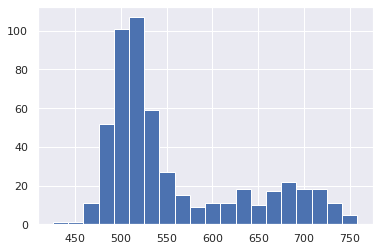

In [20]:
ax = df_enem.mediana.hist(bins=20).plot()
# ax.tick_params(which='both', bottom=False, labelbottom=False)

## Comparando distribuições das escolas

Legenda: Nome da escola <nº alunos fizeram Enem>/<posição ranking nota final>

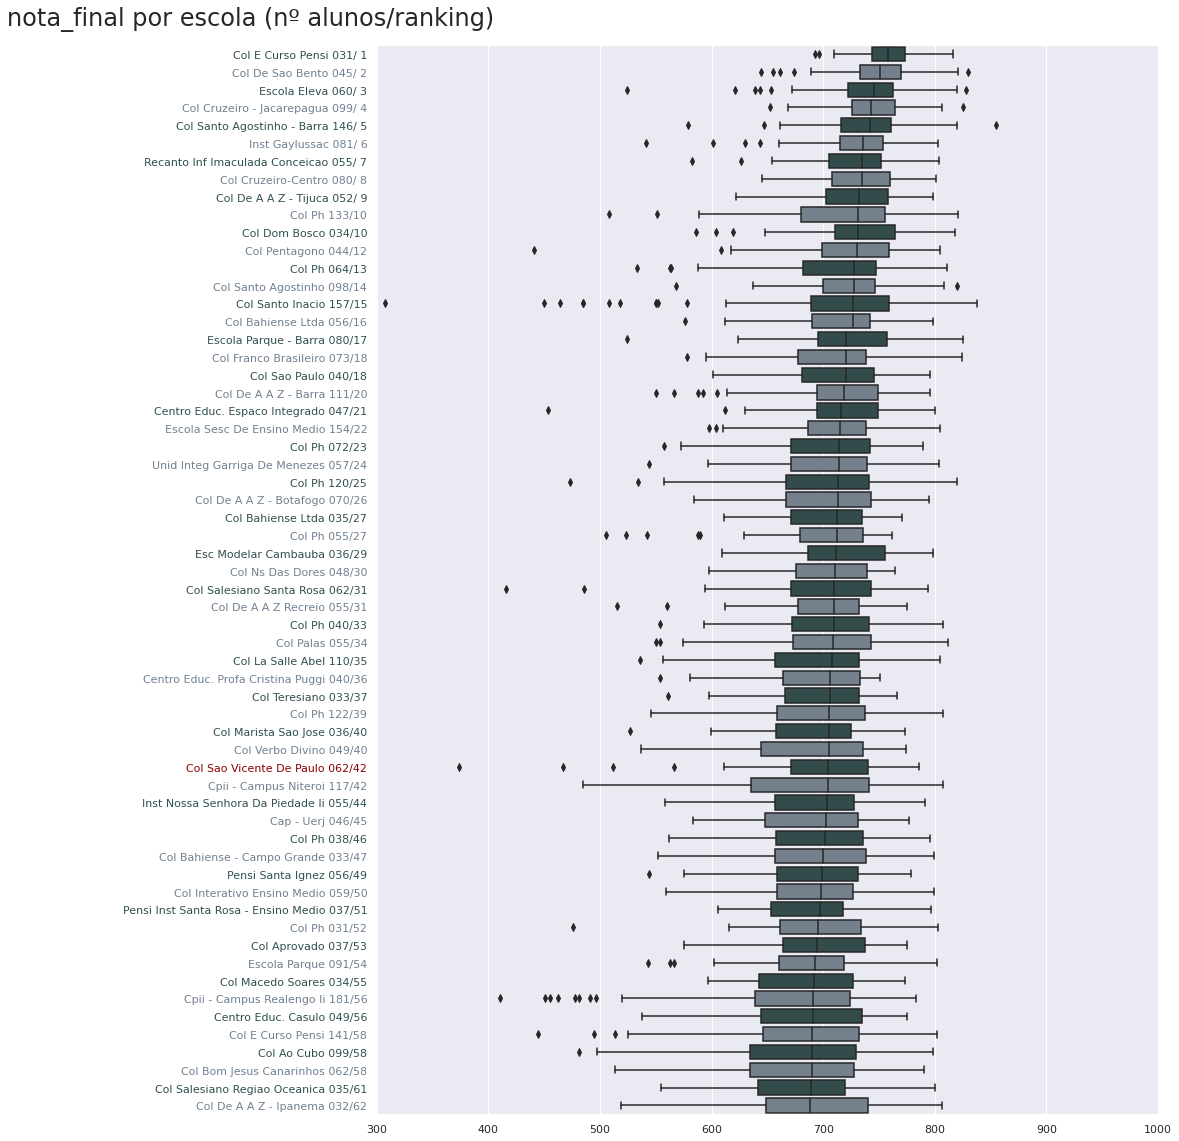

In [21]:
palette_colors = [
    "darkslategrey",
    "slategrey",
]


def compara_distribuicoes(nota, num_escolas=NUM_MELHORES):
    sns.set(rc={"figure.figsize": (14, 18), "axes.xmargin": 0.1})

    nota_agrupada = nota
    if nota == "nota_final":
        nota_agrupada = "mediana"

    df_top = df_enem.sort_values(nota_agrupada, ascending=False).head(num_escolas)
    ax = sns.boxplot(
        data=df_enem_rio,
        y="CO_ESCOLA",
        x=nota,
        orient="h",
        order=df_top.CO_ENTIDADE,
        palette=palette_colors,
    )
    ax.set(ylabel="", xlabel="")
    plt.gcf().subplots_adjust(top=0.95)
    plt.suptitle(
        f"{nota} por escola (nº alunos/ranking)",
        x=0,
        size=24,
    )
    locs, _ = plt.yticks()
    _, labels = plt.yticks(
        locs,
        df_top.rotulo,
    )
    for i in range(len(labels)):
        if "Col Sao Vicente De Paulo" in df_top.rotulo.iloc[i]:
            labels[i].set_color("DarkRed")
        else:
            labels[i].set_color(palette_colors[i % len(palette_colors)])
    ax.set_xlim(300, 1000)


compara_distribuicoes("nota_final");

Um dado estranho, o Santo Inácio tem 245 alunos que disseram que completaram agora, mas há apenas 235 no 3º ano de 2018. Será que é preenchimento errado? Será que estou contando jovens e adultos? Será que acontece o mesmo com outras escolas?

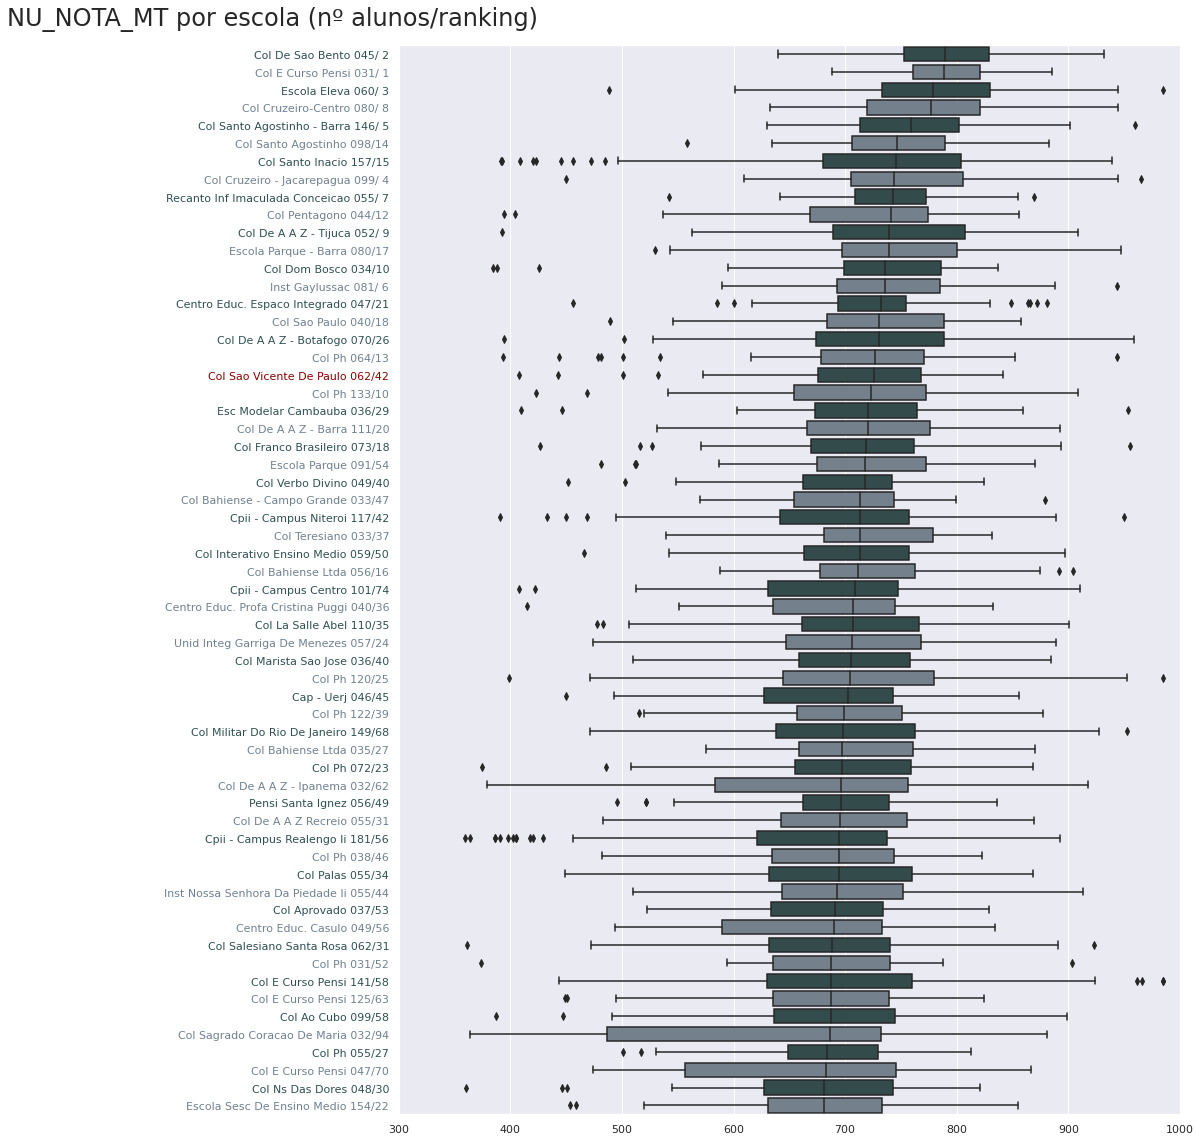

In [22]:
compara_distribuicoes("NU_NOTA_MT");

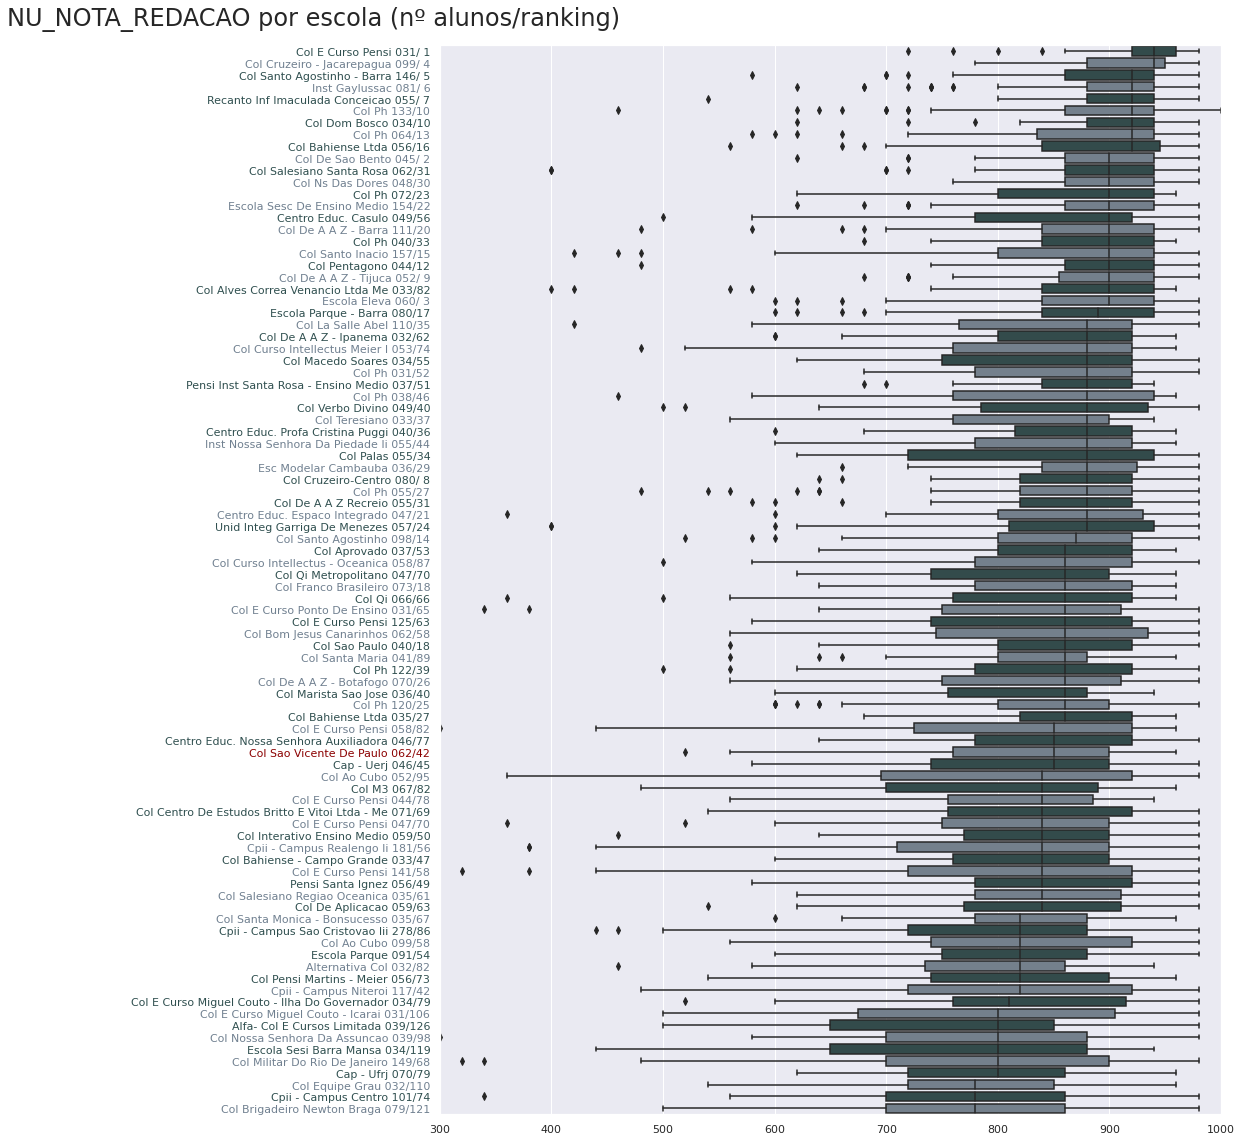

In [23]:
compara_distribuicoes("NU_NOTA_REDACAO", 90);

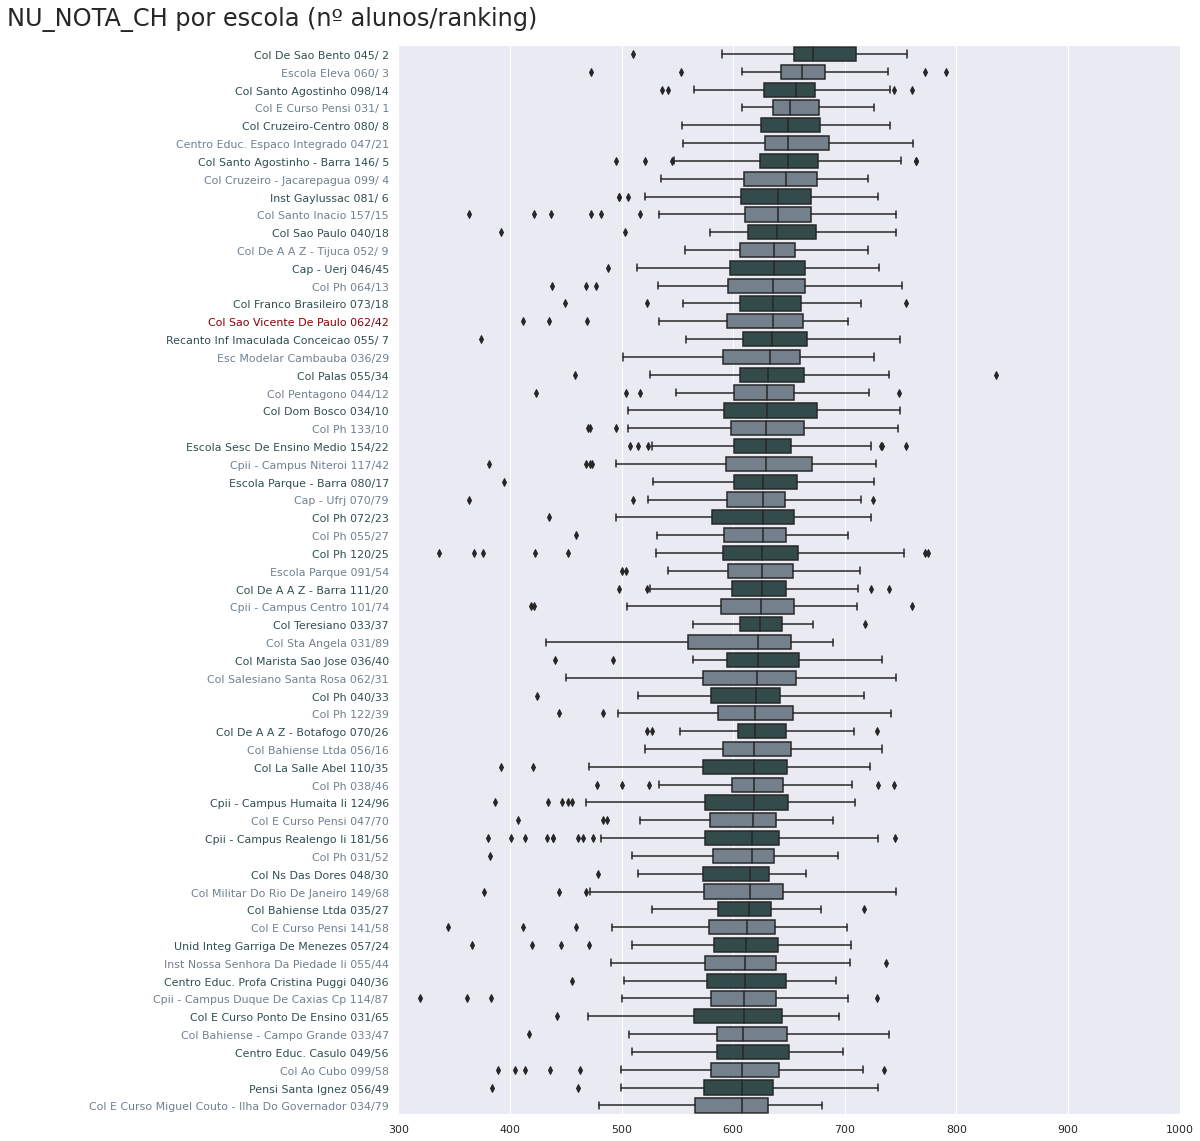

In [24]:
compara_distribuicoes("NU_NOTA_CH");

## Distribuição notas de redação

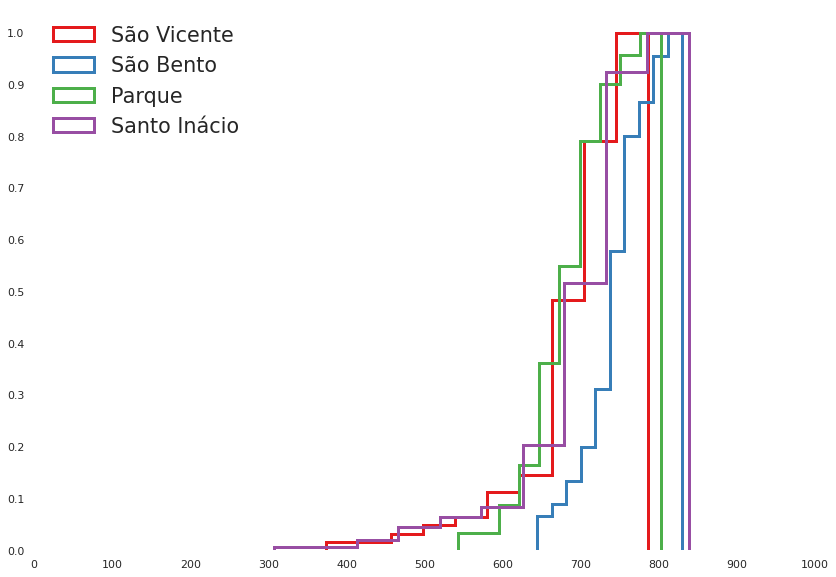

In [25]:
plt.style.use("seaborn-whitegrid")
sns.set(rc={"figure.figsize": (14, 10), "axes.xmargin": 0.1})
plt.box(False)
plt.set_cmap(plt.cm.Set2)
num_ploted = 0


def plot_cdf(co_escola, label):
    global num_ploted
    plt.hist(
        df_enem_rio.query("CO_ESCOLA == @co_escola").nota_final.dropna(),
        cumulative=True,
        histtype="step",
        linewidth=3,
        color=plt.cm.Set1.colors[num_ploted],
        density=True,  # bins=df_escola.size,
        label=label,
    )
    num_ploted += 1


plot_cdf(CO_SAO_VICENTE, "São Vicente")
plot_cdf(CO_SAO_BENTO, "São Bento")
plot_cdf(CO_PARQUE, "Parque")
plot_cdf(CO_ST_INACIO, "Santo Inácio")
plt.legend(fontsize="xx-large", framealpha=0.1, facecolor="white")

plt.yticks(np.linspace(0, 1, 11))
plt.xticks(np.linspace(0, 1000, 11));

O impressionante do São Bento é como ninguém tira nota baixa. Parece que eliminaram mesmo os piores alunos

 ## Sobrevivência no ensino médio

 Quantos dos alunos que começam o ensino médio fazem Enem?

 Motivos para diminuir:
 - Maus alunos são expulsos
 - Maus alunos não acreditam que passarão no Enem
 - Vai para universidade fora do Enem (ITAs, PUCs, USP, exterior etc.)

 Motivos para aumentar:
 - Crise econômica (escolas públicas)
 - Bolsa para bons alunos

 ### ideias
 - comparar com último ano (dá ideia melhor da seleção feita pela escola)
 - comparar com quem fez prova (ideia melhor de auto seleção)

In [26]:
plt.cm.Paired.colors

((0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392))

In [27]:
etapa_col = "TP_ETAPA_ENSINO"
primeiro_ano = [25, 30, 35]
# todo: tratar ensinos médios de 4 anos
df_primeiro_ano_turmas = pd.read_feather("dados/primeiro_ano.feather")

In [28]:
df_ano_um = df_primeiro_ano_turmas.groupby(["id_escola", "ano"])["num_matriculas"].sum()

df_ano_um = df_ano_um.unstack()
df_ano_um

ano,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
id_escola,,,,,,,,,,,,,
33000026,90.0,73.0,51.0,36.0,55.0,63.0,54.0,51.0,56.0,41.0,39.0,35.0,37.0
33000042,216.0,194.0,177.0,111.0,128.0,138.0,104.0,99.0,98.0,121.0,86.0,58.0,42.0
33000069,26.0,25.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33000077,108.0,102.0,149.0,194.0,207.0,210.0,228.0,230.0,262.0,291.0,280.0,274.0,217.0
33000115,NaN,NaN,NaN,23.0,6.0,15.0,7.0,12.0,9.0,21.0,22.0,20.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
33551219,NaN,NaN,NaN,41.0,48.0,46.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33552223,NaN,NaN,NaN,NaN,11.0,NaN,4.0,7.0,5.0,NaN,4.0,2.0,3.0
33552231,NaN,NaN,NaN,13.0,15.0,20.0,29.0,20.0,33.0,18.0,20.0,19.0,12.0


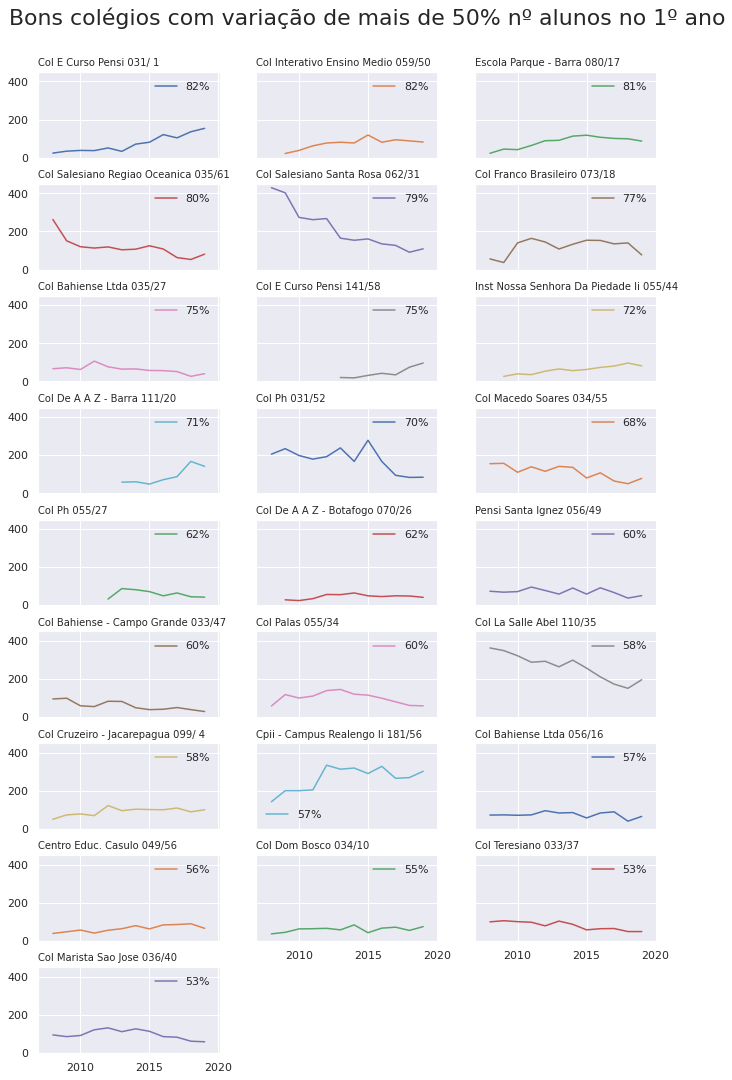

In [29]:
df_ano_um[df_ano_um == 1] = np.nan  # tem um Pensi aqui com dado esquisito
porcentagem_variacao = 0.5
anos_idx = slice(0, 11)  # colunas com dados de alunos no primeiro ano
df = (
    df_ano_um.drop(2007, axis="columns")
    .merge(
        df_enem.head(NUM_MELHORES)[["CO_ENTIDADE", "rotulo", "rank"]],
        left_index=True,
        right_on="CO_ENTIDADE",
    )  # pegando nome das escolas e só das melhores
    .set_index("rotulo")
    .assign(
        alta_variacao=lambda df: (  # variação do número de alunos
            df.iloc[:, anos_idx].max(axis="columns")
            - df.iloc[:, anos_idx].min(axis="columns")
        )
        / df.iloc[:, anos_idx].max(axis="columns")
    )
    .query("alta_variacao > @porcentagem_variacao")
    .sort_values(
        "alta_variacao", ascending=False
    )  # mostrando primeiro as com maior variação
    .drop(["CO_ENTIDADE", "rank"], axis="columns")
    .dropna(thresh=6)  # joga fora quem não tem pelo menos 6 anos preenchidos
)
alta_variacao = df.pop("alta_variacao")
df = df.T

sns.set(rc={"figure.figsize": (10, 18), "axes.xmargin": 0.1})
axes = df.plot.line(subplots=True, layout=(11, 3), sharey=True)

i = 0
for axes2 in axes:
    for ax in axes2:
        if i < len(alta_variacao):
            ax.set_title(df.columns[i], ha="left", x=0, size=10)
            # ax.legend().set_visible(False)
            ax.legend(["{:.0%}".format(alta_variacao.iloc[i])])
            # ax.set_yscale("log", base=2)
        i += 1
sns.set()
fig = plt.gcf()
fig.suptitle(
    "Bons colégios com variação de mais de {:.0%} nº alunos no 1º ano".format(
        porcentagem_variacao
    ),
    size=22,
    ha="left",
    x=0,
)
plt.subplots_adjust(hspace=0.3, wspace=0.2, left=0.04, top=0.93, bottom=0)
plt.xticks(range(2008, 2019));

Escrito na legenda acima está a variação entre o máximo e mínimo de alunos do primeiro ano de cada escola.

- Pensi tem grandes variações, tanto uma queda drástica em 2012, como um grande crescimento
- Vários colégios de Niterói/São Gonçalo perdendo alunos:  Salesiano Santa Rosa, Abel, Santa Mônica
- escola parque barra crescendo
- PH varia muito (com queda drástica no final)

## Comparando nº alunos que fizeram ENEM 2018 vs alunos no 1º ano 2016

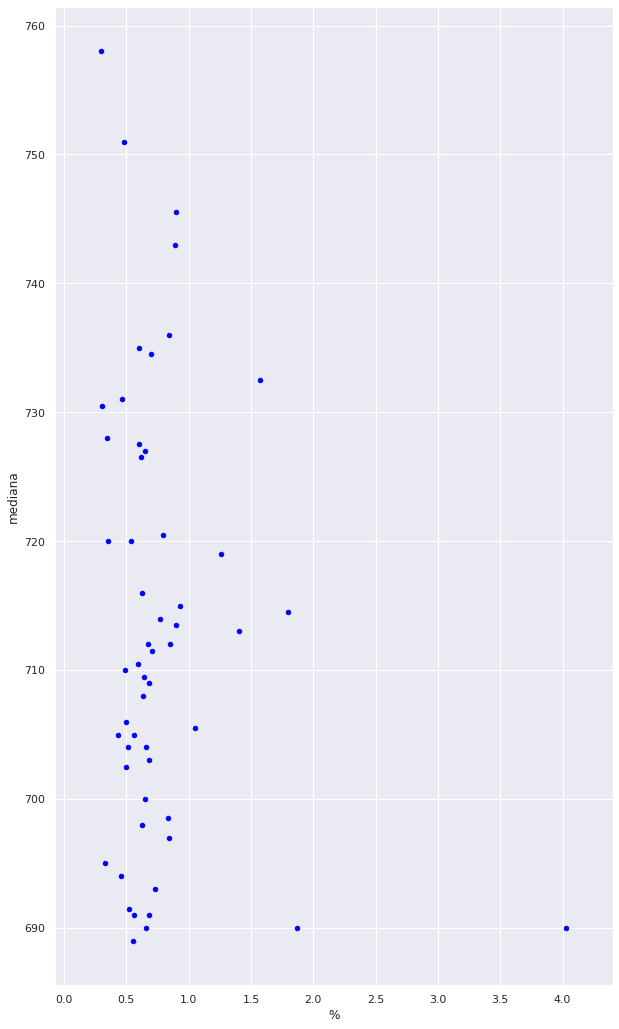

In [30]:
df = df_enem.head(NUM_MELHORES).set_index("CO_ENTIDADE")
primeiro_ano = ANO_ULT - 2
df = df.join(df_ano_um[[primeiro_ano]])
df["%"] = df.num / df[primeiro_ano]
# tirando do plot alguns outliers. Tem escola com 10 vezes mais alunos!
# df[df["%"] < 1.5]
df.plot.scatter(x="%", y="mediana", c="blue");

Entre os bem colocados, quem aumenta o número de alunos?

In [31]:
df.loc[df["%"] >= 1, ["rotulo", "%", "mediana", "rank", "num"]].sort_values(
    "%", ascending=False
)

,rotulo,%,mediana,rank,num
CO_ENTIDADE,,,,,
33166820,Col E Curso Pensi 141/58,4.028571,690.0,58.0,141
33178798,Col Ao Cubo 099/58,1.867925,690.0,58.0,99
33180539,Col Ph 072/23,1.800000,714.5,23.0,72
33173990,Col De A A Z - Tijuca 052/ 9,1.575758,732.5,9.0,52
33228604,Col De A A Z - Botafogo 070/26,1.400000,713.0,26.0,70
33447225,Col De A A Z - Barra 111/20,1.261364,719.0,20.0,111
33110328,Col Ph 122/39,1.051724,705.5,39.0,122


Quem aumenta o número de alunos? Pensi, de A a Z e PH. Estes são mais cursinhos pré-vestibular do que escolas. Pesquisando, descobri que muita gente vai para estas escolas no último ano do ensino médio para se preparar melhor para o Enem. Vou tirá-los da lista. O Colégio [Dom Bosco](https://www.colegiodombosco.com.br/) é um colégio tradicional de Resende e seu aumento foi pontual, então vou manter.

A correlação de -0.048 entre notas e perdas de alunos é fraca


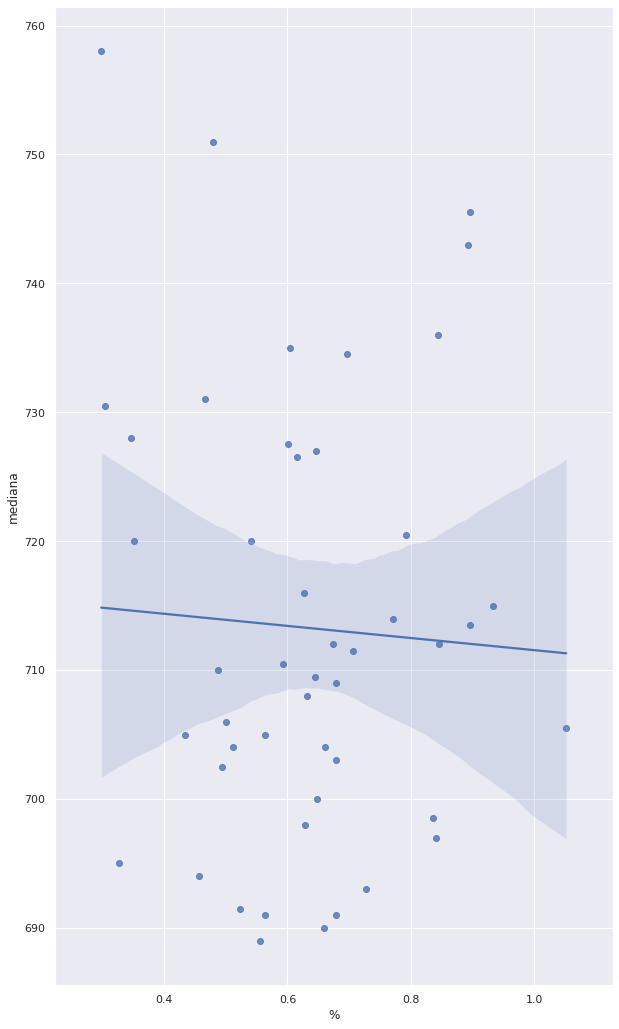

In [32]:
df_sem_outliers = df[df["%"] < 1.06]
sns.set()
sns.regplot(data=df_sem_outliers, x="%", y="mediana")
print(
    "A correlação de {:.2n} entre notas e perdas de alunos é fraca".format(
        df_sem_outliers[["%", "mediana"]].corr().iat[0, 1]
    )
)

Minha hipótese é que as melhores escolas de todas tinham um viés de seleção, eliminando seus piores alunos convidando-os a se retirar durante o ensino médio. Este pode ser o caso, mas acho que também pode acontecer o contrário. Alunos de escolas tradicionais saem para os cursinhos no último ano. Aconteceria que alguns dos alunos mais preocupados em se preparar destas escolas estariam saindo. Melhoraria o índice dos cursinhos que não os formaram.

Abaixo 2016 é o número de alunos no primeiro ano e _num_ é o número de alunos que fizeram Enem e se formaram neste ano.

In [33]:
df.loc[
    :, ["rotulo", ANO_ULT - 2, "num", "%", "mediana", "rank"]
].style.hide_index().format({"%": "{:.0%}".format})

rotulo,2017,num,%,mediana,rank
Col E Curso Pensi 031/ 1,104.000000,31,30%,758.000000,1.000000
Col De Sao Bento 045/ 2,94.000000,45,48%,751.000000,2.000000
Escola Eleva 060/ 3,67.000000,60,90%,745.500000,3.000000
Col Cruzeiro - Jacarepagua 099/ 4,111.000000,99,89%,743.000000,4.000000
Col Santo Agostinho - Barra 146/ 5,nan,146,nan%,742.000000,5.000000
Inst Gaylussac 081/ 6,96.000000,81,84%,736.000000,6.000000
Recanto Inf Imaculada Conceicao 055/ 7,91.000000,55,60%,735.000000,7.000000
Col Cruzeiro-Centro 080/ 8,115.000000,80,70%,734.500000,8.000000
Col De A A Z - Tijuca 052/ 9,33.000000,52,158%,732.500000,9.000000
Col Ph 133/10,nan,133,nan%,731.000000,10.000000


Entre os que mais diminuem o número de alunos também estão o Pensi e o PH. Impressionante, o CAP da Uerj tem bem poucos alunos fazendo Enem. Vamos dar uma olhada como os colégios que também são cursos variam de número de alunos.

In [34]:
df_cursos = df.loc[
    (df.rotulo.str.contains("Ph|Curso Pensi|A A Z")), ["rotulo", "mediana", "rank", "%"]
]
df_cursos.style.hide_index().format({"%": "{:.0%}".format})

rotulo,mediana,rank,%
Col E Curso Pensi 031/ 1,758.000000,1.000000,30%
Col De A A Z - Tijuca 052/ 9,732.500000,9.000000,158%
Col Ph 133/10,731.000000,10.000000,nan%
Col Ph 064/13,728.000000,13.000000,35%
Col De A A Z - Barra 111/20,719.000000,20.000000,126%
Col Ph 072/23,714.500000,23.000000,180%
Col Ph 120/25,713.500000,25.000000,90%
Col De A A Z - Botafogo 070/26,713.000000,26.000000,140%
Col Ph 055/27,712.000000,27.000000,85%
Col De A A Z Recreio 055/31,710.000000,31.000000,nan%


A variação de alunos destes cursos é impressionante. O melhor colocado tem menos de metade dos alunos do início do ensino médio. Enquanto outros tem um aumento impressionante. Não parece uma comparação justa com as escolas mais tradicionais. 

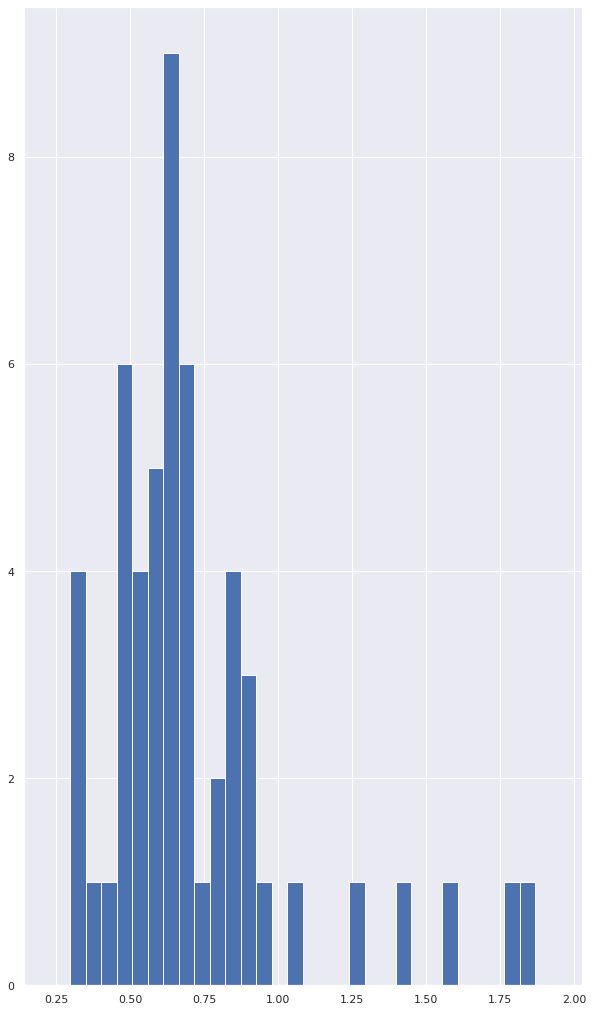

In [35]:
df.loc[df["%"] < 4, "%"].hist(bins=30).plot();

In [36]:
df.loc[df["%"] < 4, "%"].describe()

count    53.000000
mean      0.718873
std       0.333881
min       0.298077
25%       0.523077
50%       0.646091
75%       0.835821
max       1.867925
Name: %, dtype: float64

In [37]:
df["%"].quantile([i / 10 for i in range(11)])

0.0    0.298077
0.1    0.440651
0.2    0.497849
0.3    0.562452
0.4    0.617641
0.5    0.646575
0.6    0.678790
0.7    0.772451
0.8    0.864449
0.9    1.198472
1.0    4.028571
Name: %, dtype: float64

In [38]:
# isso aqui é enrolado. Entre as NUM_ESCOLAS melhores escolas, quais mais cortam alunos entre
# primeiro ano e o Enem?
menor_quantil = df["%"].quantile(0.2)  # arbitrário
menor_quantil

0.4978494623655914

In [39]:
df.shape

(60, 12)

In [40]:
df_enem.head()

,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,mediana,num,rank,NO_ENTIDADE,CO_ENTIDADE,rotulo
1603,647.70,650.80,626.90,788.90,940.0,758.0,31,1.0,COL E CURSO PENSI,33135827,Col E Curso Pensi 031/ 1
1230,636.60,671.90,626.10,789.60,900.0,751.0,45,2.0,COL DE SAO BENTO,33062633,Col De Sao Bento 045/ 2
1967,609.80,661.90,625.90,779.00,900.0,745.5,60,3.0,ESCOLA ELEVA,33178860,Escola Eleva 060/ 3
214,613.20,647.00,620.30,743.80,940.0,743.0,99,4.0,COL CRUZEIRO - JACAREPAGUA,33135371,Col Cruzeiro - Jacarepagua 099/ 4
244,605.55,649.05,620.45,759.25,920.0,742.0,146,5.0,COL SANTO AGOSTINHO - BARRA,33176825,Col Santo Agostinho - Barra 146/ 5


## Seleção de escolas para ranking

Retirando quem eu não quero contar:
- quem aumenta o número de alunos (só fica o Dom Bosco com variação 1.02)
- quem corta aluno demais, isto é os 80% que menos cortam, isto é, pelo menos 64% dos alunos do 1º ano devem fazer Enem (não verifico se são os mesmos alunos). Isso privilegia as escolas que menos cortam alunos. Por outro lado prejudica escolas cujos bons alunos foram para outra escola.
- Pelo menos 35 alunos fazendo Enem. 


Os 2 primeiro critérios cortam quase todos os cursinhos: Pensi, A a Z e PH

E depois vem o critério mais radical. Contarei quantos alunos eriam 64% do primeiro ano e contarei apenas este número das melhores notas. Isto privilegiará as escolas que mantém um número de alunos constante do primeiro ao último ano do ensino médio. 

In [41]:
df_escolas_selecionadas = df.loc[
    (df["%"] < 1.02) & (df["%"] >= 0.62) & (df["num"] >= 35),  # menor_quantil) &
    ["rotulo", 2016, "%"],
]
print(
    "Antes dos cortes tínhamos {:n} melhores escolas, depois ficamos com {:n}, cortando {:.1%}".format(
        NUM_MELHORES,
        len(df_escolas_selecionadas),
        (NUM_MELHORES - len(df_escolas_selecionadas)) / NUM_MELHORES,
    )
)

KeyError: '[2016] not in index'

Agora vem o radical, pegaremos apenas os melhores 64 percentil das notas.

In [ ]:
# df_escolas_selecionadas ['num_candidatos_considerados'] = (df_escolas_selecionadas[[2016]] * menor_quantil).round().astype('int16')
df_escolas_selecionadas["num_candidatos_considerados"] = (
    (df_escolas_selecionadas[[2016]] * 0.7).round().astype("int16")
)
df_escolas_selecionadas

In [ ]:
df_melhores_alunos = pd.concat(
    g.nlargest(
        df_escolas_selecionadas.at[escola_id, "num_candidatos_considerados"],
        columns="nota_final",
    )
    for escola_id, g in df_escolas_selecionadas[["rotulo"]]
    .merge(
        df_enem_rio.sort_values(["CO_ESCOLA", "nota_final"]),
        left_index=True,
        right_on="CO_ESCOLA",
    )
    .groupby("CO_ESCOLA")
)
df_melhores_alunos = df_enem_rio
df_final = notas_enem(df_melhores_alunos).join(
    df_escolas_selecionadas[["rotulo"]], how="inner"
)
df_final["rank"] = df_final.mediana.rank(ascending=False, method="min")
df_final

#     notas_agg = {col: (col, 'median') for col in notas_cols}
#     notas_agg['mediana'] = ('nota_final', 'median')
#     notas_agg['num'] = ('nota_final', 'count')

#     return df_enem_rio.groupby('CO_ESCOLA')\
#                       .agg(**notas_agg)\
#                       .sort_values('mediana', ascending=False)\
#                       .query('num > @MIN_ALUNOS')#corte arbitrário

In [ ]:
df_final.reset_index().to_feather("dados/final.feather")

In [ ]:
# dever de casa

- analisar colégios que estão com NAN na percentagem acima, especialmente o **Santo Agostinho Barra**
- checar no santo inácio os alunos EJA e os que estão refazendo o Enem